# Projectile Motion Lab

In elementary physics courses, one often sees the projectile motion problem without air resistance, for which the solution is fully analytic and straightforward:
* The maximum range occurs at a $45^\circ$ launch angle,
* The horizontal range is given by the well-known formula $R = (v_0^2/g) \sin(2\theta)$.

However, if we include **air resistance**, the situation becomes more complicated.

This lab shows:
1. No Air Resistance: Simple closed-form solution and a quick check via **gradient descent**.
2. Linear Air Resistance: An analytic solution for $x(t)$ and $y(t)$ is still possible, although the time-of-flight can only be solved implicitly (involving a transcendental equation).
   We can still implement a **gradient descent** on the angle $\alpha$, using these closed-form expressions plus a (small) numerical step to find the time of flight.

## Gradient Descent for Maximum Range (No Air Resistance)

We consider a projectile launched from the ground at an initial speed $v_0$ and an angle $\theta$ with respect to the horizontal.
The only force acting on the projectile is gravity, which causes a uniform downward acceleration $g$.
The motion can be decomposed into horizontal and vertical components.
\begin{align}
\frac{dx}{dt}   = v_x, &\quad \frac{dy}{dt}   = v_y; \\
\frac{dv_x}{dt} = 0,   &\quad \frac{dv_y}{dt} = -g.
\end{align}

The solution can be obtained by the kinematic equations:
\begin{align}
x &= v_0\cos(\theta)\;t, \\
y &= v_0\sin(\theta)\;t - \frac{1}{2}gt^2.
\end{align}
where we chose $x(t=0) = 0$ and $y(t=0) = 0$.

The **time of flight** is simply the non-trivial root of $y(t)$, which has the analytical form
\begin{align}
  T = \frac{2 v_0 \sin(\theta)}{g}.
\end{align}

Substituting this into $x(t)$, the horizontal range is
\begin{align}
R = x(T) = 2\frac{v_0^2}{g}\sin(\theta)\cos(\theta).
\end{align}
Using the double angle identities $\sin(2\theta) \equiv 2\sin(\theta)\cos(\theta)$, we obtain the **horizontal range equation**
\begin{align}
R(\theta) = \frac{v_0^2}{g}\sin(2\theta)
\end{align}

Holding $v_0$ and $g$ fix, clearly, $R(\theta)$ reaches the longest range at $\sin$'s peak, i.e., $2\theta = \pi/2$.
This is nothing but the well known result that the maximum range occurs at a $\theta = \pi/4 = 45^\circ$ launch angle.

In this part of the lab, we will use gradient descent to confirm this numerically.

### Task 1: Implement the Range Function

The horizontal range of a projectile launched at an angle $\theta$ is:
\begin{align}
R(\theta) = \frac{v_0^2}{g} \sin(2\theta).
\end{align}
Define a Python function `R_proj(theta, v0, g)` that computes $R(\theta)$.

In [8]:
# HANDSON: Implement the range equation

from jax import numpy as np

def R_proj(theta, v0, g):
    range = (v0 ** 2 / g) * np.sin(2 * theta)
    return range

In [9]:
# HANDSON: implement autodg_hist() with early stop that checks `abs(X[-1] - X[-2]) < tol`

from jax import grad

def autogd_hist(f, x, alpha, imax=1000, tol=1e-6):
    df = grad(f)
    X  = [x]
    for _ in range(imax):
        X.append(X[-1] - alpha * df(X[-1]))
        if abs(X[-1] - X[-2]) < tol:
            break
    return X

In [10]:
import matplotlib.pyplot as plt

# Parameters
v0 = 10    # Initial velocity (m/s)
g  = 9.81  # Gravity (m/s^2)

# Gradient Descent Optimization
theta = np.radians(30)  # Initial guess (in radians)
alpha = 0.01            # Learning rate

# HANSON: Define a loss function L(theta) based on R_proj but depends only on theta
f = lambda alpha: -R_proj(alpha, v0, g)

# HANSON: Use autograd_hist() to obtain the history of Theta
Theta = autogd_hist(f, theta, alpha)

In [11]:
# Convert results to degrees
Theta_deg = np.degrees(np.array(Theta))

# Print result
print(f"Optimized launch angle (degrees): {Theta_deg[-1]}")

Optimized launch angle (degrees): 44.99994659423828


Text(0, 0.5, 'Launch Angle (degrees)')

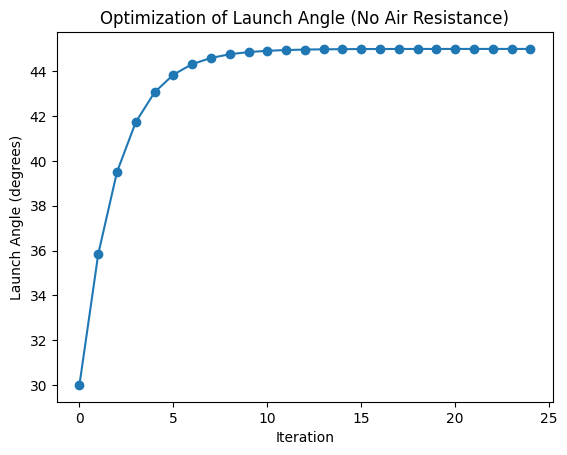

In [12]:
# Plot results

plt.plot(Theta_deg, '-o')
plt.title('Optimization of Launch Angle (No Air Resistance)')
plt.xlabel('Iteration')
plt.ylabel('Launch Angle (degrees)')

## Gradient Descent for Maximum Range with Air Resistance

When air resistance is included, the force acting on the projectile consists of two components:
* **Gravity**: $- mg\hat{j}$
* **Air Resistance**: $-k\mathbf{v}$, where $k$ is the drag coefficient and $\mathbf{v} = (v_x, v_y)$ is the velocity.

Defining $\gamma = k/m$ as the damping coefficient, Newton's second law gives the system of differential equations:
\begin{align}
\frac{d v_x}{dt} &=    - \gamma v_x, \\
\frac{d v_y}{dt} &= -g - \gamma v_y.
\end{align}

The first equation is a simple separable differential equation.
Integrating both sides and using the initial condition $v_x(0) = v_0 \cos(\theta)$,
\begin{align}
v_x(t) = v_0 \cos(\theta)\,e^{-\gamma t}.
\end{align}

Using the integrating factor method, the general solution to the second equation is
\begin{align}
v_y = e^{-\gamma t} \left( C - \int g e^{\gamma t} dt \right).
\end{align}

Solving the integral and using the initial condition $v_y(0) = v_0 \sin(\theta)$, we have
\begin{align}
v_y(t)
= \left( v_0 \sin\theta + \frac{g}{\gamma} \right) e^{-\gamma t} - \frac{g}{\gamma}
\end{align}
Note that $v_\text{t} \equiv g/\gamma$ is the terminating velocity.
Hence the vertical equation can be rewritten as:
\begin{align}
v_y(t)
= v_0 \sin(\theta)\;e^{-\gamma t} - v_\text{t}(1 - e^{-\gamma t}).
\end{align}

Integrating $v_x(t)$ and $v_y(t)$ in time, we obtain the complicated but still analytical equations
\begin{align}
x(t) &= \frac{v_0 \cos\theta}{\gamma} \left( 1 - e^{-\gamma t} \right)\\
y(t) &= \frac{v_0 \sin\theta + v_\text{t}}{\gamma} \left(1 - e^{-\gamma t} \right) - v_\text{t} t.
\end{align}

The **flight of time** in this case, i.e., the non-trivial root of $y(t)$ does not have an analytical solution.
While it is possible to use a root finder to solve it numerically, for this hands-on lab, we will make a simplification.

Event without air resistance, i.e., when $\gamma = 0$, the **flight of time at 0 air resistance** $T_0$ is finite.
Hence, we can consider the situation that $\gamma \ll 1 / T_0$.
This allows us to Taylor expansion the horizontal equation
\begin{align}
y(t) 
&\approx \frac{v_0 \sin\theta + v_\text{t}}{\gamma} \left(\gamma t - \frac{\gamma^2 t^2}{2}\right) - v_\text{t} t \\
&= v_0 \sin(\theta)\;t - \frac{\gamma v_0\sin\theta + g}{2}\;t^2.
\end{align}

Hence, the corrected **flight of time at small air resistance** is
\begin{align}
T_\gamma \approx \frac{2v_0\sin\theta}{\gamma v_0\sin\theta + g}.
\end{align}

Keeping the horizontal equation at the same order and substitute the flight of time, we have
\begin{align}
R = x(T_\gamma) \approx v_0\cos(\theta) T_\gamma \approx \frac{v_0^2\sin 2\theta}{\gamma v_0\sin\theta + g}.
\end{align}

Holding $v_0$, $g$, and $\gamma$ fix, we can find the longest range by maximizing:
\begin{align}
R(\theta) \approx \frac{v_0^2\sin 2\theta}{\gamma v_0\sin\theta + g}.
\end{align}

In [16]:
# HANDSON: Implement flight of time

def T_flight(theta, v0, g, gamma=0):
    time = (2 * v0 * np.sin(theta)) / (gamma * v0 * np.sin(theta) + g)
    return time

In [17]:
# HANDSON: Implement the range equation

def R_proj(theta, v0, g, gamma=0):
    range = (v0 ** 2 * np.sin(2 * theta)) / (gamma * v0 * np.sin(theta) + g)

In [18]:
# Parameters
v0    = 10    # Initial velocity (m/s)
g     = 9.81  # Gravity (m/s^2)
gamma = 0.05  # Damping coefficient (1/s)

# Gradient Descent Optimization
theta = np.radians(30)  # Initial guess (in radians)
alpha = 0.01            # Learning rate

# HANSON: Define a loss function L(theta) based on R_proj but depends only on theta
f = lambda alpha: -R_proj(alpha, v0, g)

# HANSON: Use autograd_hist() to obtain the history of Theta
Theta = autogd_hist(f, theta, alpha)

TypeError: bad operand type for unary -: 'NoneType'

In [ ]:
# HANDSON: use T_flight() to check if we expect a good approximation

pass

In [ ]:
# Convert results to degrees
Theta_deg = np.degrees(np.array(Theta))

# Print result
print(f"Optimized launch angle (degrees): {Theta_deg[-1]}")

In [ ]:
# Plot results

plt.plot(Theta_deg, '-o')
plt.title(f'Optimization of Launch Angle with Air Resistance {gamma}')
plt.xlabel('Iteration')
plt.ylabel('Launch Angle (degrees)')